<a href="https://colab.research.google.com/github/Fayis-PV/100_ML_Projects/blob/main/4.Email_Spam_Detection_TF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [56]:
email_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/emails.csv')
email_df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [57]:
email_df.shape

(5728, 2)

<Axes: xlabel='spam', ylabel='count'>

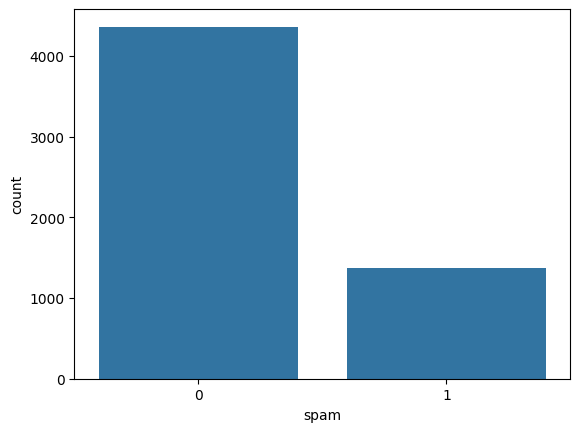

In [58]:
sns.countplot(data = email_df, x = 'spam')

DownSampling the dataset

In [59]:
ham_msg = email_df[email_df['spam'] == 0]
spam_msg = email_df[email_df['spam'] == 1]

ham_msg = ham_msg.sample(n = len(spam_msg), random_state = 42)
balanced_df = pd.concat([ham_msg,spam_msg],ignore_index=True)
balanced_df.head()

,text,spam
0,Subject: interview schedule for jinbaek kim i...,0
1,"Subject: re : wednesday meeting eric , i thi...",0
2,Subject: re : london research group i ' d do ...,0
3,"Subject: re : congratulations vince , thanks ...",0
4,Subject: osman sezgen steve kromer is request...,0


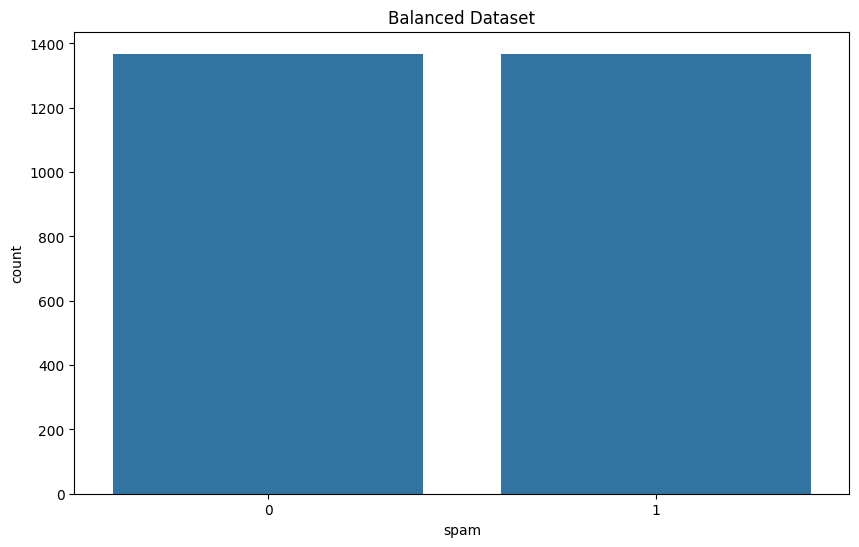

In [60]:
plt.figure(figsize=(10,6))
sns.countplot(data = balanced_df, x = 'spam')
plt.title('Balanced Dataset')
plt.show()

Text Processing

Textual data is highly unstructured and need attention in many aspects:

* Stopwords Removal
* Punctuations Removal
* Stemming or Lemmatization

In [61]:
balanced_df['text'] = balanced_df['text'].apply(lambda x: x.replace(x[:8],'') if x.startswith('Subject:') else x)
balanced_df['text'] = balanced_df['text'].apply(lambda x: x.translate(str.maketrans('','',string.punctuation,)))
balanced_df['text'] = balanced_df['text'].apply(lambda x: x.lower())

In [62]:
def remove_stopwords(text):
  stopwords_list = set(stopwords.words('english'))
  filtered_words = [word for word in text.split() if word.lower() not in stopwords_list]
  return ' '.join(filtered_words)

balanced_df['text'] = balanced_df['text'].apply(remove_stopwords)
balanced_df.head()

,text,spam
0,interview schedule jinbaek kim see went happy ...,0
1,wednesday meeting eric think skip meeting disc...,0
2,london research group soon possible call exact...,0
3,congratulations vince thanks note congratulati...,0
4,osman sezgen steve kromer requesting osman spe...,0


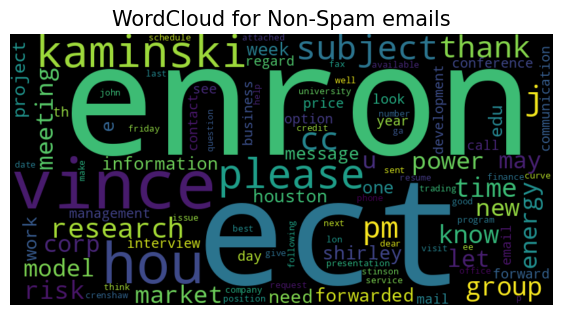

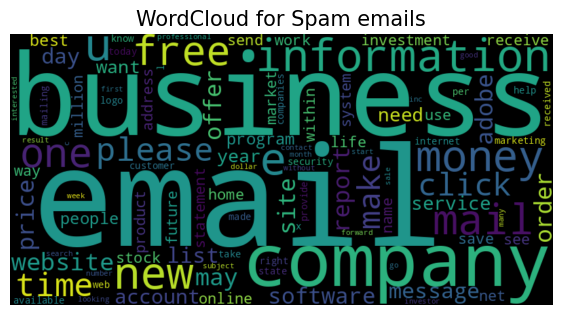

In [63]:
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])

    plt.figure(figsize=(7, 7))

    wc = WordCloud(background_color='black',
                   max_words=100,
                   width=800,
                   height=400,
                   collocations=False).generate(email_corpus)

    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} emails', fontsize=15)
    plt.axis('off')
    plt.show()

plot_word_cloud(balanced_df[balanced_df['spam'] == 0], typ='Non-Spam')
plot_word_cloud(balanced_df[balanced_df['spam'] == 1], typ='Spam')

Split Dataset

In [64]:
X_train,X_test,y_train,y_test = train_test_split(balanced_df['text'],balanced_df['spam'],test_size=0.2,stratify=balanced_df['spam'],random_state=42)


Word2Vec Tokenizer

In [65]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)



max_len = 100
train_padded = pad_sequences(train_sequences,maxlen=max_len,padding='post',truncating='post')
test_padded = pad_sequences(test_sequences,maxlen=max_len,padding='post',truncating='post')



Model Development

In [66]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = 32, input_length= max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [67]:
model.compile(loss= tf.keras.losses.BinaryCrossentropy(from_logits= True), optimizer='adam', metrics=['accuracy'])


In [68]:
es = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True,)
lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=0 )

In [69]:
history = model.fit(train_padded,y_train,epochs=15,validation_data=(test_padded,y_test),callbacks=[es,lr])

Epoch 1/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.5846 - loss: 0.6791 - val_accuracy: 0.8905 - val_loss: 0.4101 - learning_rate: 0.0010
Epoch 2/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9585 - loss: 0.2627 - val_accuracy: 0.9471 - val_loss: 0.1970 - learning_rate: 0.0010
Epoch 3/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.9513 - loss: 0.1834 - val_accuracy: 0.9617 - val_loss: 0.1623 - learning_rate: 0.0010
Epoch 4/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.9610 - loss: 0.1507 - val_accuracy: 0.9635 - val_loss: 0.1541 - learning_rate: 0.0010
Epoch 5/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9662 - loss: 0.1422 - val_accuracy: 0.9690 - val_loss: 0.1427 - learning_rate: 0.0010
Epoch 6/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9787 - loss: 0.0985 - val_accuracy: 0.9690 - val_loss: 0.1454 - learning_rate: 0.0010
Epoch 7/15
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9778 - loss: 0.0973 - val_acc

In [70]:
test_loss, test_acc = model.evaluate(test_padded,y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9626 - loss: 0.1548
Test Loss: 0.1426626443862915
Test Accuracy: 0.9689781069755554


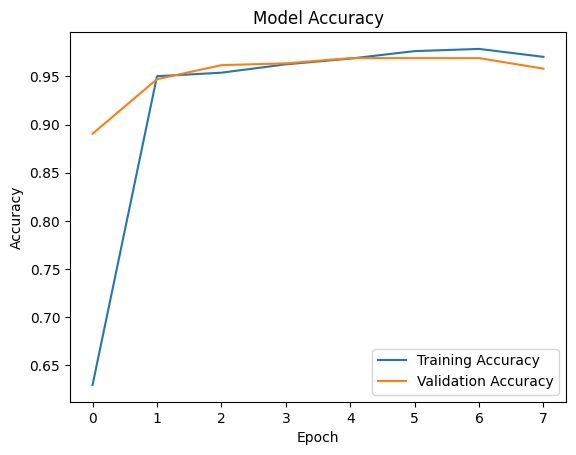

In [71]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()